In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('База.csv')

In [3]:
df.head()

,appeal_id,start_dttm,participants_desc,appeal_type_nm,bot_dialog_time_sec,appeal_time_sec,employee_dialog_time_sec,repeated_24h_flg,repeated_48h_flg,repeated_5d_flg,...,help_line_calls_cnt,client_segment_nm,age_segment_nm,m_segment_flg,s_segment_flg,auto_segment_nm,travel_segment_nm,client_type_nm,subscription_nm,final_grade_code
0,1f34342d935fb740a3ce961868a08ca1,2025-06-10 17:26:05,Сотрудник,call,0,286,189,1,1,1,...,0.0,Доходные,Взрослые,0.0,0.0,Не определен,Самостоятельный,Pro,Про,NaN
1,8840fca3bbb09ace84a86c9b7935f752,2025-06-12 07:27:25,Бот+сотрудник,chat,25,1633,148,0,1,1,...,NaN,Защищенные,Не определен,0.0,0.0,Не определен,Не определен,Pro,Про,NaN
2,627179884028d1c089d176f7388d69f2,2025-06-03 17:42:44,Бот+сотрудник,chat,18,3552,572,0,0,0,...,NaN,Малодоходные,Взрослые,0.0,0.0,Траты,Самостоятельный,NaN,NaN,NaN
3,25f84aee47dd1ef1f0b8d9a7d21c1738,2025-06-09 19:05:18,Бот+сотрудник,chat,40,8146,307,0,0,0,...,NaN,Малодоходные,Взрослые,0.0,0.0,Не определен,Не определен,NaN,NaN,NaN
4,19c9ab4df48e1c0180cff905abef0040,2025-06-05 20:33:21,Бот+сотрудник,chat,623,12877,465,1,1,1,...,NaN,Малодоходные,Сеньоры,0.0,0.0,Не определен,Не определен,NaN,NaN,NaN


In [4]:
df['participants_desc'].unique()

array(['Сотрудник', 'Бот+сотрудник', 'Не определено'], dtype=object)

In [5]:
df['participants_desc'].value_counts()

participants_desc
Бот+сотрудник    226615
Сотрудник         33645
Не определено         2
Name: count, dtype: int64

In [6]:
df.isna().sum()

appeal_id                        0
start_dttm                       0
participants_desc                0
appeal_type_nm                   0
bot_dialog_time_sec              0
appeal_time_sec                  0
employee_dialog_time_sec         0
repeated_24h_flg                 0
repeated_48h_flg                 0
repeated_5d_flg                  0
domain_nm                        0
id_client                       11
gender_cd                     2048
csat_score                       0
appeal_cost_rub_amt              0
transfer_cnt                140402
task_cnt                    236342
problem_id                     283
problem_status_code            805
repeated_appeal_flg              0
help_line_calls_cnt         167456
client_segment_nm            15063
age_segment_nm                4490
m_segment_flg                 4490
s_segment_flg                 4490
auto_segment_nm               4490
travel_segment_nm             4490
client_type_nm              152839
subscription_nm     

In [7]:
df['subscription_nm'].value_counts()

subscription_nm
Про        77373
Премиум    29324
Прайват      726
Name: count, dtype: int64

In [8]:
df['final_grade_code'].value_counts()

final_grade_code
premium_bronze     35784
premium_silver      4718
premium_gold        2050
premium_diamond     1292
Name: count, dtype: int64

In [27]:
X = df.copy()
X = X.dropna(subset=['transfer_cnt'])
X.drop(['help_line_calls_cnt', 'task_cnt', 'problem_status_code'], axis=1, inplace=True)
X['client_type_nm'] = X['client_type_nm'].fillna('NAN')
X['subscription_nm'] = X['subscription_nm'].fillna('NAN')
X['final_grade_code'] = X['final_grade_code'].fillna('NAN')
X.dropna(inplace=True)
X['time_diff'] = X['appeal_time_sec'] - X['employee_dialog_time_sec'] - X['bot_dialog_time_sec']

Q1 = X['time_diff'].quantile(0.25)
Q3 = X['time_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X = X[(X['time_diff'] >= lower_bound) & (X['time_diff'] <= upper_bound)]

y = X['csat_score']

In [10]:
X.shape

(110114, 27)

In [28]:
from catboost import CatBoostClassifier

X = X.drop(['csat_score', 'appeal_id', 'id_client', 'problem_id', 'start_dttm'], axis=1, inplace=False)

cat_features = ['participants_desc', 'appeal_type_nm', 'domain_nm', 'gender_cd', 'client_segment_nm', 'age_segment_nm', 'auto_segment_nm', 'travel_segment_nm', 'client_type_nm', 'subscription_nm', 'final_grade_code']

model = CatBoostClassifier(verbose=2, random_state=42, iterations=1000, depth=3, l2_leaf_reg=4)
model.fit(X, y, cat_features=cat_features)

0:	learn: 1.5363755	total: 68.8ms	remaining: 1m 8s
2:	learn: 1.4166767	total: 189ms	remaining: 1m 2s
4:	learn: 1.3198603	total: 323ms	remaining: 1m 4s
6:	learn: 1.2386857	total: 456ms	remaining: 1m 4s
8:	learn: 1.1703053	total: 582ms	remaining: 1m 4s
10:	learn: 1.1120514	total: 705ms	remaining: 1m 3s
12:	learn: 1.0613797	total: 825ms	remaining: 1m 2s
14:	learn: 1.0172615	total: 953ms	remaining: 1m 2s
16:	learn: 0.9786291	total: 1.08s	remaining: 1m 2s
18:	learn: 0.9442504	total: 1.21s	remaining: 1m 2s
20:	learn: 0.9135598	total: 1.33s	remaining: 1m 2s
22:	learn: 0.8858789	total: 1.46s	remaining: 1m 1s
24:	learn: 0.8612970	total: 1.58s	remaining: 1m 1s
26:	learn: 0.8387661	total: 1.7s	remaining: 1m 1s
28:	learn: 0.8189091	total: 1.84s	remaining: 1m 1s
30:	learn: 0.8006166	total: 1.97s	remaining: 1m 1s
32:	learn: 0.7838465	total: 2.09s	remaining: 1m 1s
34:	learn: 0.7688980	total: 2.22s	remaining: 1m 1s
36:	learn: 0.7553030	total: 2.36s	remaining: 1m 1s
38:	learn: 0.7427914	total: 2.49s	re

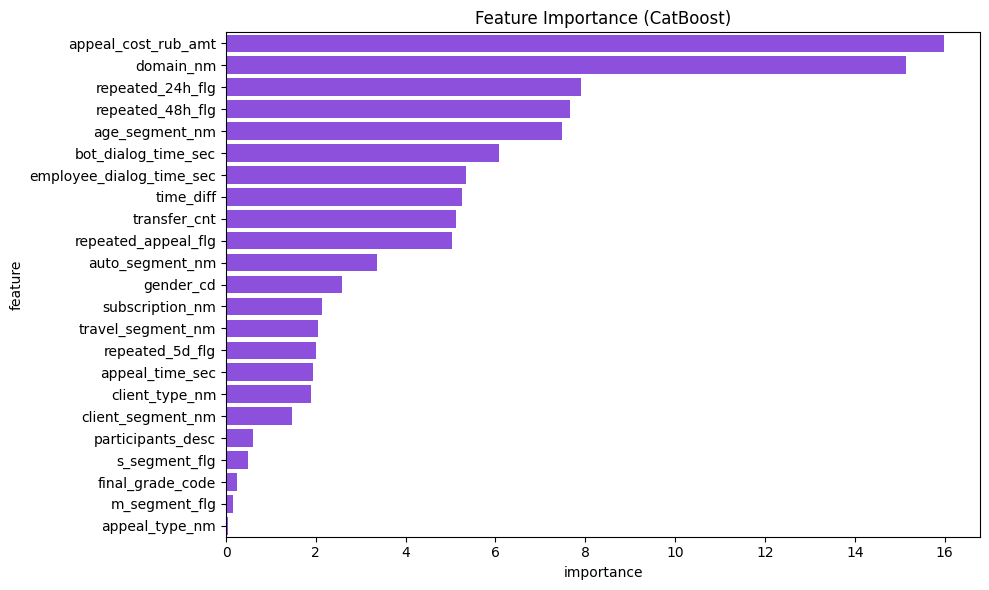

In [29]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, color="#8A38F5")
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()

<Axes: ylabel='appeal_cost_rub_amt'>

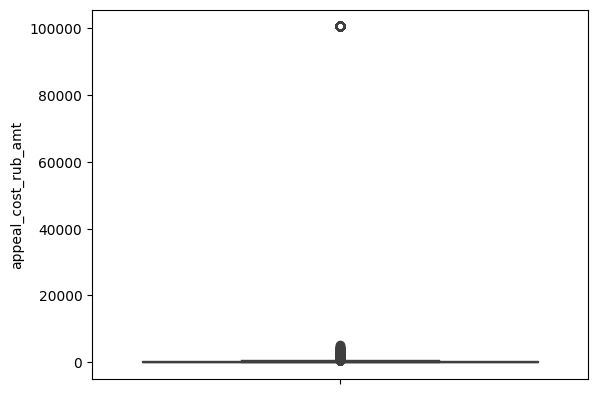

In [13]:
sns.boxplot(X['appeal_cost_rub_amt'])

=== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ===
CSAT 1 (недовольны):
  Количество наблюдений: 11167
  Среднее число трансферов: 0.330
  Стандартное отклонение: 1.020
  Медиана: 0.000

CSAT 5 (довольны):
  Количество наблюдений: 68479
  Среднее число трансферов: 0.205
  Стандартное отклонение: 0.516
  Медиана: 0.000


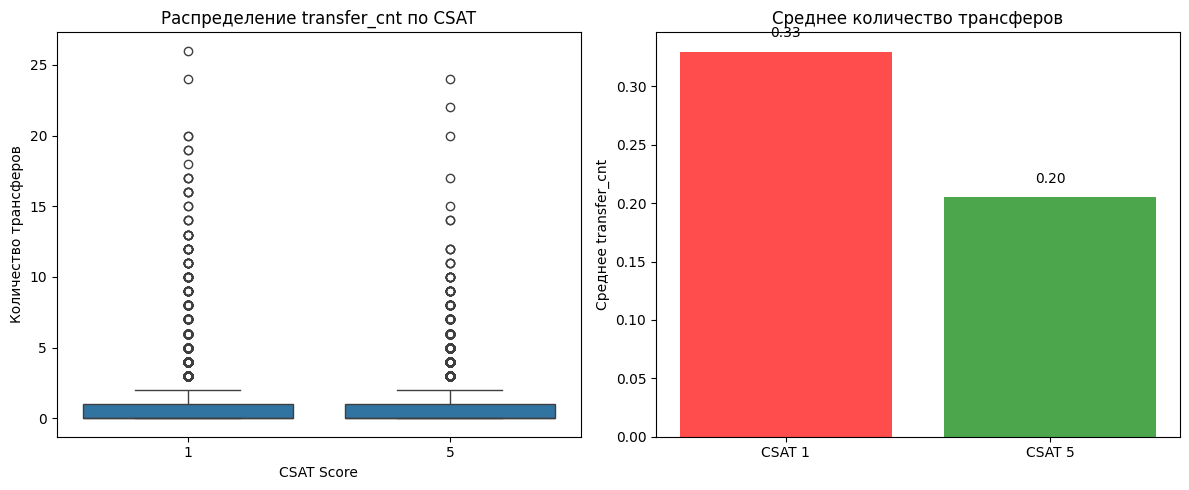


=== РЕЗУЛЬТАТЫ T-ТЕСТА ===
T-статистика: 19.982
P-value: 0.000
✅ Статистически значимая разница между группами (p < 0.05)
💡 Недовольные клиенты (CSAT 1) имеют БОЛЬШЕ трансферов

=== ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ (95%) ===
CSAT 1: 0.311 - 0.349
CSAT 5: 0.201 - 0.209


In [30]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

X = df.copy()
X = X.dropna(subset=['transfer_cnt'])
X.drop(['help_line_calls_cnt', 'task_cnt', 'problem_status_code'], axis=1, inplace=True)
X['client_type_nm'] = X['client_type_nm'].fillna('NAN')
X['subscription_nm'] = X['subscription_nm'].fillna('NAN')
X['final_grade_code'] = X['final_grade_code'].fillna('NAN')
X.dropna(inplace=True)
X['time_diff'] = X['appeal_time_sec'] - X['employee_dialog_time_sec'] - X['bot_dialog_time_sec']

Q1 = X['time_diff'].quantile(0.25)
Q3 = X['time_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X = X[(X['time_diff'] >= lower_bound) & (X['time_diff'] <= upper_bound)]

y = X['csat_score']

# Фильтруем данные только для csat_score 1 и 5
csat_1 = X[X['csat_score'] == 1]['transfer_cnt']
csat_5 = X[X['csat_score'] == 5]['transfer_cnt']

# Считаем описательную статистику
print("=== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ===")
print(f"CSAT 1 (недовольны):")
print(f"  Количество наблюдений: {len(csat_1)}")
print(f"  Среднее число трансферов: {csat_1.mean():.3f}")
print(f"  Стандартное отклонение: {csat_1.std():.3f}")
print(f"  Медиана: {csat_1.median():.3f}")

print(f"\nCSAT 5 (довольны):")
print(f"  Количество наблюдений: {len(csat_5)}")
print(f"  Среднее число трансферов: {csat_5.mean():.3f}")
print(f"  Стандартное отклонение: {csat_5.std():.3f}")
print(f"  Медиана: {csat_5.median():.3f}")

# Визуализация
plt.figure(figsize=(12, 5))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='csat_score', y='transfer_cnt', 
           data=df[df['csat_score'].isin([1, 5])])
plt.title('Распределение transfer_cnt по CSAT')
plt.xlabel('CSAT Score')
plt.ylabel('Количество трансферов')

# Bar plot со средними значениями
plt.subplot(1, 2, 2)
means = [csat_1.mean(), csat_5.mean()]
labels = ['CSAT 1', 'CSAT 5']
plt.bar(labels, means, color=['red', 'green'], alpha=0.7)
plt.title('Среднее количество трансферов')
plt.ylabel('Среднее transfer_cnt')
for i, v in enumerate(means):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Проводим t-тест
t_stat, p_value = ttest_ind(csat_1, csat_5)  # Welch's t-test

print(f"\n=== РЕЗУЛЬТАТЫ T-ТЕСТА ===")
print(f"T-статистика: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Интерпретация
if p_value < 0.05:
    print("✅ Статистически значимая разница между группами (p < 0.05)")
    if csat_1.mean() > csat_5.mean():
        print("💡 Недовольные клиенты (CSAT 1) имеют БОЛЬШЕ трансферов")
    else:
        print("💡 Довольные клиенты (CSAT 5) имеют БОЛЬШЕ трансферов")
else:
    print("❌ Нет статистически значимой разницы между группами (p ≥ 0.05)")

# Дополнительно: доверительные интервалы
from scipy.stats import sem, t

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return mean - h, mean + h

ci_1 = confidence_interval(csat_1)
ci_5 = confidence_interval(csat_5)

print(f"\n=== ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ (95%) ===")
print(f"CSAT 1: {ci_1[0]:.3f} - {ci_1[1]:.3f}")
print(f"CSAT 5: {ci_5[0]:.3f} - {ci_5[1]:.3f}")

<Axes: xlabel='appeal_cost_rub_amt', ylabel='Count'>

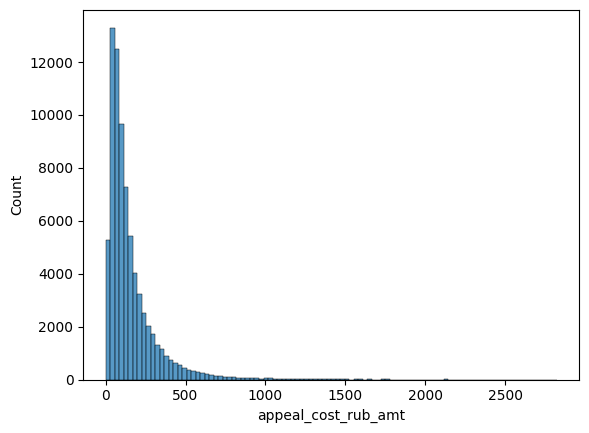

In [31]:
sns.histplot(X[X['appeal_cost_rub_amt'] < 3000]['appeal_cost_rub_amt'], bins=100)

In [ ]:
X.shape

(110114, 22)

In [32]:
X = df.copy()
X = X.dropna(subset=['transfer_cnt'])
X.drop(['help_line_calls_cnt', 'task_cnt', 'problem_status_code'], axis=1, inplace=True)
X['client_type_nm'] = X['client_type_nm'].fillna('NAN')
X['subscription_nm'] = X['subscription_nm'].fillna('NAN')
X['final_grade_code'] = X['final_grade_code'].fillna('NAN')
X.dropna(inplace=True)
X['time_diff'] = X['appeal_time_sec'] - X['employee_dialog_time_sec'] - X['bot_dialog_time_sec']

Q1 = X['time_diff'].quantile(0.25)
Q3 = X['time_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X = X[(X['time_diff'] >= lower_bound) & (X['time_diff'] <= upper_bound)]

y = X['csat_score']

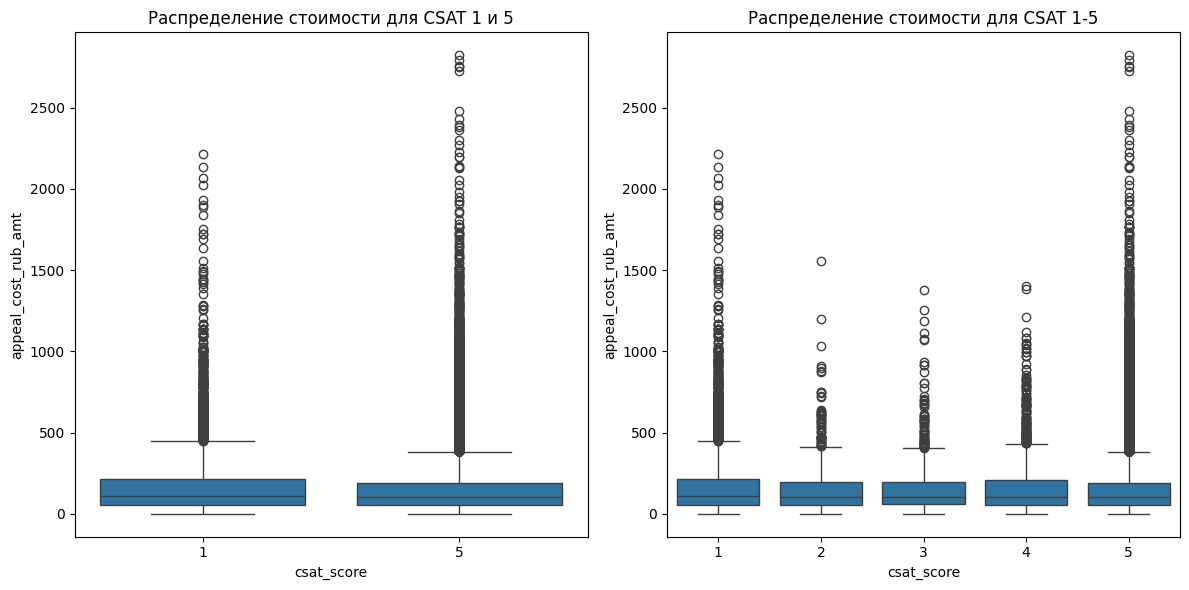

Средняя стоимость обращения по оценкам CSAT:
csat_score
1    168.503546
2    153.874994
3    155.992250
4    161.452082
5    152.441751
Name: appeal_cost_rub_amt, dtype: float64


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X = X[X['appeal_cost_rub_amt'] < 3000]

# Данные уже загружены в DataFrame X

# Вариант 1: Сравнение только оценок 1 и 5
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
data_1_5 = X[X['csat_score'].isin([1, 5])]
sns.boxplot(x='csat_score', y='appeal_cost_rub_amt', data=data_1_5)
plt.title('Распределение стоимости для CSAT 1 и 5')

# Вариант 2: Все оценки от 1 до 5
plt.subplot(1, 2, 2)
sns.boxplot(x='csat_score', y='appeal_cost_rub_amt', data=X)
plt.title('Распределение стоимости для CSAT 1-5')

plt.tight_layout()
plt.show()

# Дополнительно: вывод средних значений для каждой группы
mean_costs = X.groupby('csat_score')['appeal_cost_rub_amt'].mean()
print("Средняя стоимость обращения по оценкам CSAT:")
print(mean_costs)

In [34]:
import scipy.stats as stats
import numpy as np

# Фильтруем данные для оценок 1 и 5
group_1 = X[X['csat_score'] == 1]['appeal_cost_rub_amt']
group_5 = X[X['csat_score'] == 5]['appeal_cost_rub_amt']

# Проверяем нормальность распределения (тест Шапиро-Уилка)
normality_1 = stats.shapiro(group_1)
normality_5 = stats.shapiro(group_5)

print("Тест на нормальность распределения:")
print(f"CSAT 1: статистика = {normality_1.statistic:.3f}, p-value = {normality_1.pvalue:.3f}")
print(f"CSAT 5: статистика = {normality_5.statistic:.3f}, p-value = {normality_5.pvalue:.3f}")

# Проверяем равенство дисперсий (тест Левена)
levene_test = stats.levene(group_1, group_5)
print(f"\nТест на равенство дисперсий (Левене): статистика = {levene_test.statistic:.3f}, p-value = {levene_test.pvalue:.3f}")

# Выполняем t-тест (разные варианты в зависимости от условий)
if levene_test.pvalue > 0.05:
    # Если дисперсии равны, используем стандартный t-тест
    t_stat, p_value = stats.ttest_ind(group_1, group_5, equal_var=True)
    test_type = "стандартный t-тест (равные дисперсии)"
else:
    # Если дисперсии не равны, используем t-тест Уэлча
    t_stat, p_value = stats.ttest_ind(group_1, group_5, equal_var=False)
    test_type = "t-тест Уэлча (неравные дисперсии)"

print(f"\nРезультаты t-теста ({test_type}):")
print(f"t-статистика = {t_stat:.3f}, p-value = {p_value}")

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("\nСтатистически значимые различия между группами обнаружены (p < 0.05).")
    # Определяем направление различий
    mean_1 = np.mean(group_1)
    mean_5 = np.mean(group_5)
    print(f"Средняя стоимость для CSAT 1: {mean_1} руб.")
    print(f"Средняя стоимость для CSAT 5: {mean_5} руб.")
    
    if mean_1 > mean_5:
        print("Обращения с оценкой 1 имеют статистически значимо более высокую стоимость.")
    else:
        print("Обращения с оценкой 5 имеют статистически значимо более высокую стоимость.")
else:
    print("\nСтатистически значимых различий между группами не обнаружено (p ≥ 0.05).")

# Дополнительно: непараметрический тест Манна-Уитни (если данные не нормальны)
if normality_1.pvalue < 0.05 or normality_5.pvalue < 0.05:
    print("\nТак как распределение не нормальное, рекомендуется использовать непараметрический тест:")
    u_stat, p_value_mannwhitney = stats.mannwhitneyu(group_1, group_5)
    print(f"Тест Манна-Уитни: U-статистика = {u_stat:.3f}, p-value = {p_value_mannwhitney}")

Тест на нормальность распределения:
CSAT 1: статистика = 0.698, p-value = 0.000
CSAT 5: статистика = 0.687, p-value = 0.000

Тест на равенство дисперсий (Левене): статистика = 93.990, p-value = 0.000

Результаты t-теста (t-тест Уэлча (неравные дисперсии)):
t-статистика = 7.586, p-value = 3.585061168890541e-14

Статистически значимые различия между группами обнаружены (p < 0.05).
Средняя стоимость для CSAT 1: 168.5035455412494 руб.
Средняя стоимость для CSAT 5: 152.44175074747284 руб.
Обращения с оценкой 1 имеют статистически значимо более высокую стоимость.

Так как распределение не нормальное, рекомендуется использовать непараметрический тест:
Тест Манна-Уитни: U-статистика = 274212184.000, p-value = 3.1488571147507144e-07


/home/lambda/projects/dano/hse_spb_hackiton/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8388.
  res = hypotest_fun_out(*samples, **kwds)
/home/lambda/projects/dano/hse_spb_hackiton/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 63213.
  res = hypotest_fun_out(*samples, **kwds)


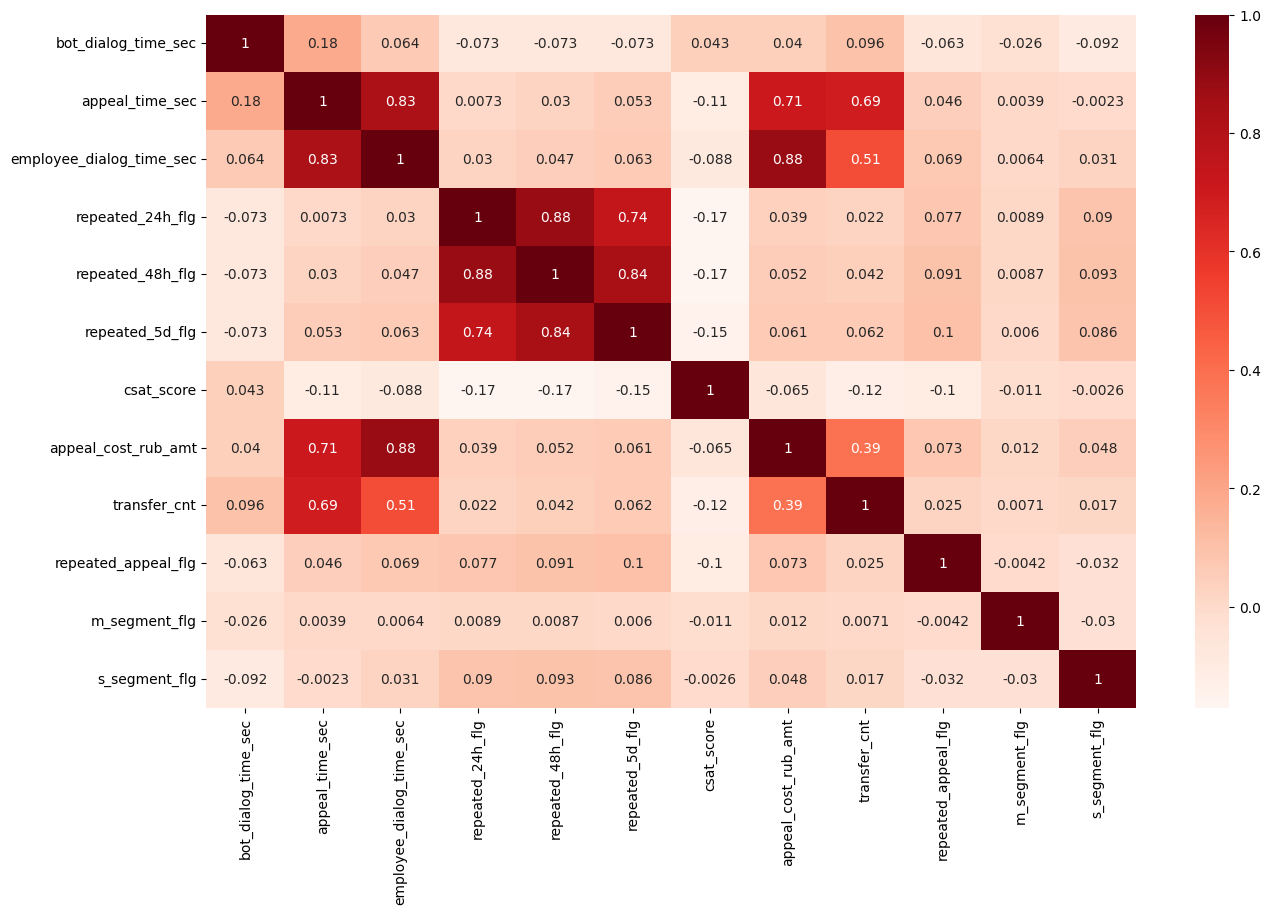

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 9))
sns.heatmap(
    X.select_dtypes(include=np.number).corr(method='spearman'),  
    annot=True,
    cmap='Reds'
)
plt.show()


<Axes: xlabel='domain_nm', ylabel='Count'>

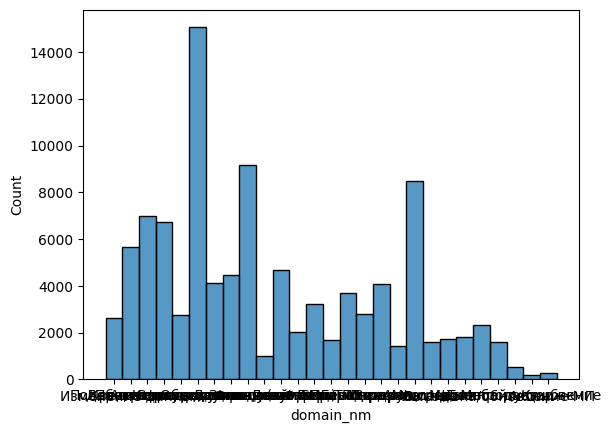

In [ ]:
sns.histplot(X['domain_nm'])

In [ ]:
X['domain_nm']

0                        Пополнения
6                  Изменение данных
7                          Антифрод
8                          Антифрод
9                Дебетовые продукты
                    ...            
260247           Дебетовые продукты
260248         Массовое расторжение
260252    Кредитные продукты для ФЛ
260255    Кредитные продукты для ФЛ
260260                     Т-Мобайл
Name: domain_nm, Length: 100751, dtype: object

In [47]:
X = df.copy()
X = X.dropna(subset=['transfer_cnt'])
X.drop(['help_line_calls_cnt', 'task_cnt', 'problem_status_code'], axis=1, inplace=True)
X['client_type_nm'] = X['client_type_nm'].fillna('NAN')
X['subscription_nm'] = X['subscription_nm'].fillna('NAN')
X['final_grade_code'] = X['final_grade_code'].fillna('NAN')
X.dropna(inplace=True)
X['time_diff'] = X['appeal_time_sec'] - X['employee_dialog_time_sec'] - X['bot_dialog_time_sec']
X = X[X['time_diff'] > 0]
y = X['csat_score']


Основные статистики:
transfer_cnt: mean=0.51, std=0.87
time_diff: mean=2826.37, std=54708.52


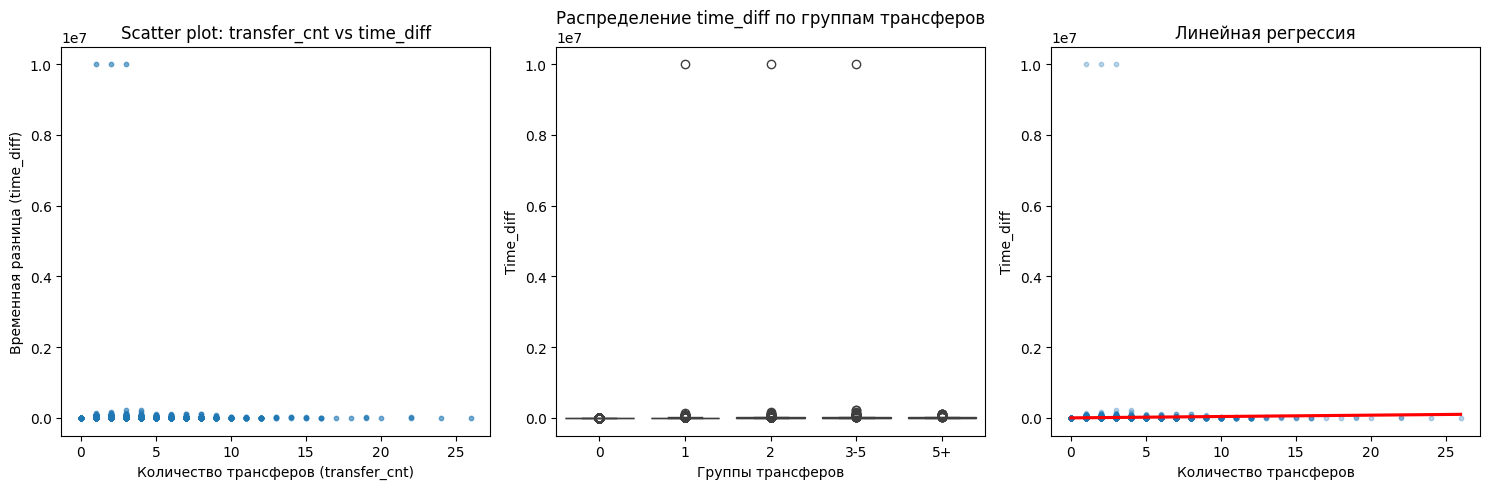


=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ===
Корреляция Пирсона: 0.061
P-value (Пирсон): 3.211e-85
Корреляция Спирмена: 0.594
P-value (Спирмен): 0.000e+00

=== OLS РЕГРЕССИЯ ===
                            OLS Regression Results                            
Dep. Variable:              time_diff   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     383.4
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           3.21e-85
Time:                        12:21:32   Log-Likelihood:            -1.2581e+06
No. Observations:              102060   AIC:                         2.516e+06
Df Residuals:                  102058   BIC:                         2.516e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Основные статистики
print(f"\nОсновные статистики:")
print(f"transfer_cnt: mean={X['transfer_cnt'].mean():.2f}, std={X['transfer_cnt'].std():.2f}")
print(f"time_diff: mean={X['time_diff'].mean():.2f}, std={X['time_diff'].std():.2f}")

# 1. Визуализация зависимости
plt.figure(figsize=(15, 5))

# Scatter plot
plt.subplot(1, 3, 1)
plt.scatter(X['transfer_cnt'], X['time_diff'], alpha=0.6, s=10)
plt.xlabel('Количество трансферов (transfer_cnt)')
plt.ylabel('Временная разница (time_diff)')
plt.title('Scatter plot: transfer_cnt vs time_diff')

# Boxplot по группам трансферов
plt.subplot(1, 3, 2)
# Группируем для лучшей визуализации
X['transfer_group'] = pd.cut(X['transfer_cnt'], 
                                   bins=[-1, 0, 1, 2, 5, 100], 
                                   labels=['0', '1', '2', '3-5', '5+'])
sns.boxplot(x='transfer_group', y='time_diff', data=X)
plt.xlabel('Группы трансферов')
plt.ylabel('Time_diff')
plt.title('Распределение time_diff по группам трансферов')

# Линейный тренд
plt.subplot(1, 3, 3)
sns.regplot(x='transfer_cnt', y='time_diff', data=X, 
           scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
plt.xlabel('Количество трансферов')
plt.ylabel('Time_diff')
plt.title('Линейная регрессия')

plt.tight_layout()
plt.show()

# 2. Корреляционный анализ
print("\n=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ===")

# Пирсон (линейная корреляция)
corr_pearson, p_pearson = pearsonr(X['transfer_cnt'], X['time_diff'])
print(f"Корреляция Пирсона: {corr_pearson:.3f}")
print(f"P-value (Пирсон): {p_pearson:.3e}")

# Спирмен (ранговая корреляция)
corr_spearman, p_spearman = spearmanr(X['transfer_cnt'], X['time_diff'])
print(f"Корреляция Спирмена: {corr_spearman:.3f}")
print(f"P-value (Спирмен): {p_spearman:.3e}")

# 3. OLS регрессия
print("\n=== OLS РЕГРЕССИЯ ===")

# Добавляем константу
y = X['time_diff']
X = sm.add_constant(X['transfer_cnt'])

# Строим модель
model = sm.OLS(y, X).fit()

# Выводим результаты
print(model.summary())

X = df.copy()
X = X.dropna(subset=['transfer_cnt'])
X.drop(['help_line_calls_cnt', 'task_cnt', 'problem_status_code'], axis=1, inplace=True)
X['client_type_nm'] = X['client_type_nm'].fillna('NAN')
X['subscription_nm'] = X['subscription_nm'].fillna('NAN')
X['final_grade_code'] = X['final_grade_code'].fillna('NAN')
X.dropna(inplace=True)
X['time_diff'] = X['appeal_time_sec'] - X['employee_dialog_time_sec'] - X['bot_dialog_time_sec']

Q1 = X['time_diff'].quantile(0.25)
Q3 = X['time_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X = X[(X['time_diff'] >= lower_bound) & (X['time_diff'] <= upper_bound)]
X = X[X['time_diff'] > 0]

y = X['csat_score']

# 4. Дополнительный анализ: средние значения по группам
print("\n=== СРЕДНИЕ ЗНАЧЕНИЯ ПО ГРУППАМ ТРАНСФЕРОВ ===")
group_stats = X.groupby('transfer_cnt')['time_diff'].agg(['mean', 'count', 'std']).round(2)
print(group_stats.head(10))  # Показываем первые 10 групп

# 5. Проверка значимости разницы между группами
# Сравним группы с 0 и 1+ трансферами
group_0 = X[X['transfer_cnt'] == 0]['time_diff']
group_1plus = X[X['transfer_cnt'] >= 1]['time_diff']

t_stat, p_val = ttest_ind(group_0, group_1plus, equal_var=False)
print(f"\nT-тест: 0 трансферов vs 1+ трансферов")
print(f"T-статистика: {t_stat:.3f}")
print(f"P-value: {p_val:.3e}")

# Интерпретация результатов
print(f"\n=== ИНТЕРПРЕТАЦИЯ ===")
if corr_pearson < 0 and p_pearson < 0.05:
    print("✅ Подтверждена ОБРАТНАЯ корреляция:")
    print(f"   Коэффициент: {corr_pearson:.3f}")
    print(f"   Статистическая значимость: p < 0.05")
    
    # Интерпретация OLS
    coef = model.params['transfer_cnt']
    print(f"   OLS коэффициент: {coef:.3f}")
    print(f"   Каждый дополнительный трансфер уменьшает time_diff на {abs(coef):.2f} единиц")
else:
    print("❌ Обратная корреляция не подтверждена статистически")

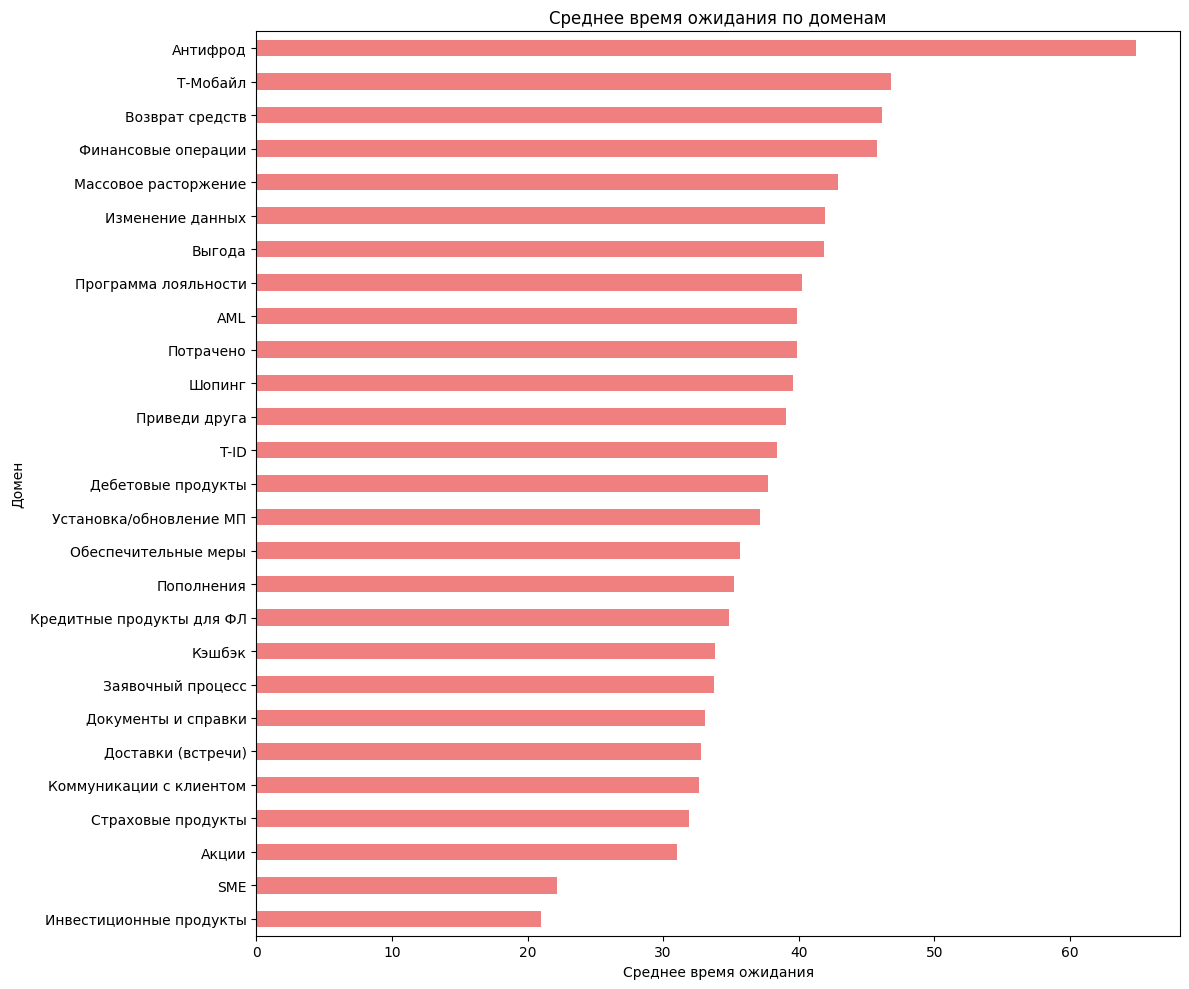

In [49]:
plt.figure(figsize=(12, 10))
domain_stats_sorted = X.groupby('domain_nm')['time_diff'].mean().sort_values()

domain_stats_sorted.plot(kind='barh', color='lightcoral')
plt.title('Среднее время ожидания по доменам')
plt.xlabel('Среднее время ожидания')
plt.ylabel('Домен')
plt.tight_layout()
plt.show()

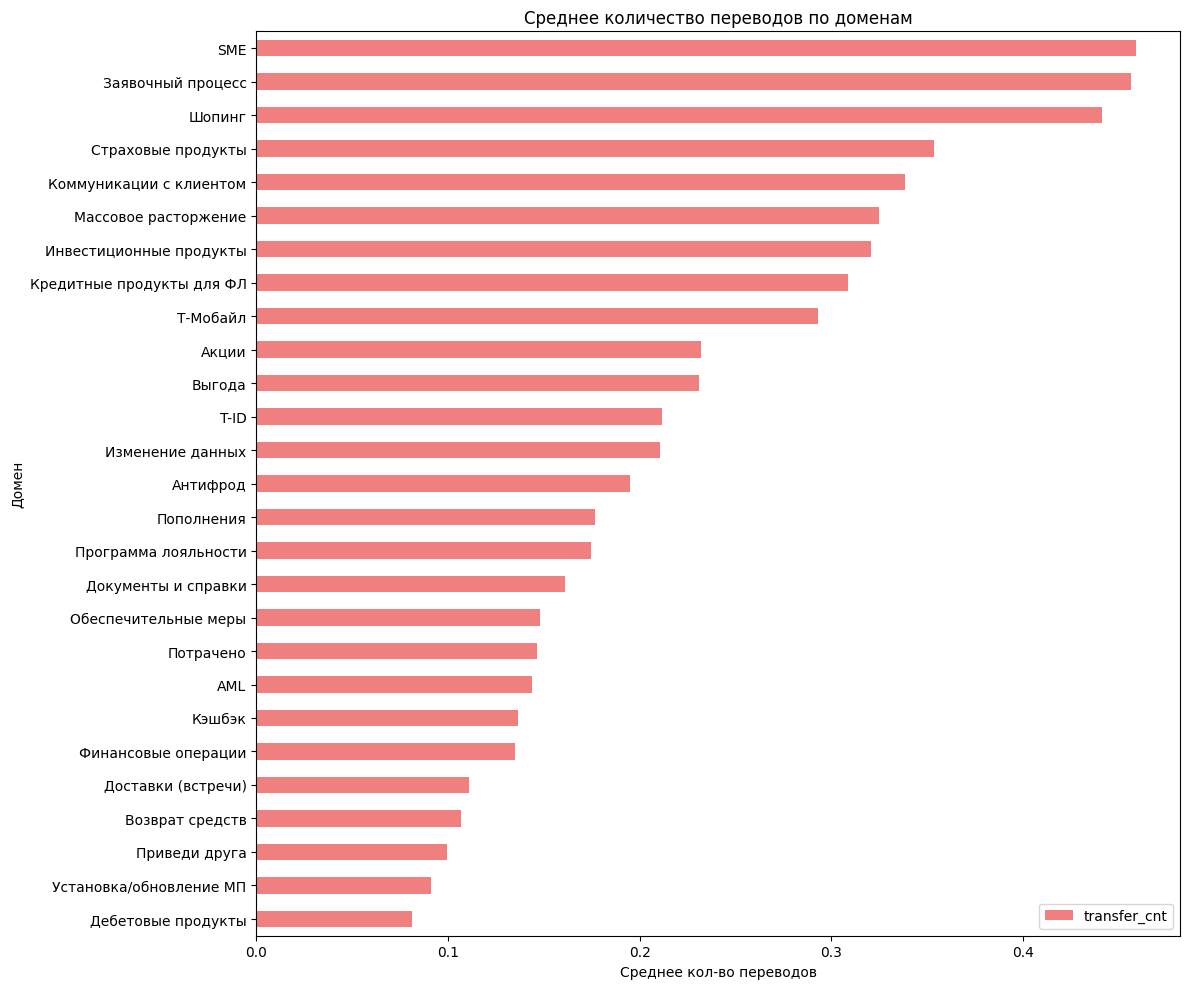

In [82]:
plt.figure(figsize=(12, 10))
domain_stats_sorted = X.groupby('domain_nm')['transfer_cnt'].mean().sort_values()

# Вычисляем общее среднее количество переводов
overall_mean = X['transfer_cnt'].mean()

domain_stats_sorted.plot(kind='barh', color='lightcoral')
plt.title('Среднее количество переводов по доменам')
plt.xlabel('Среднее кол-во переводов')
plt.ylabel('Домен')

# Добавляем легенду
plt.legend()

plt.tight_layout()
plt.show()

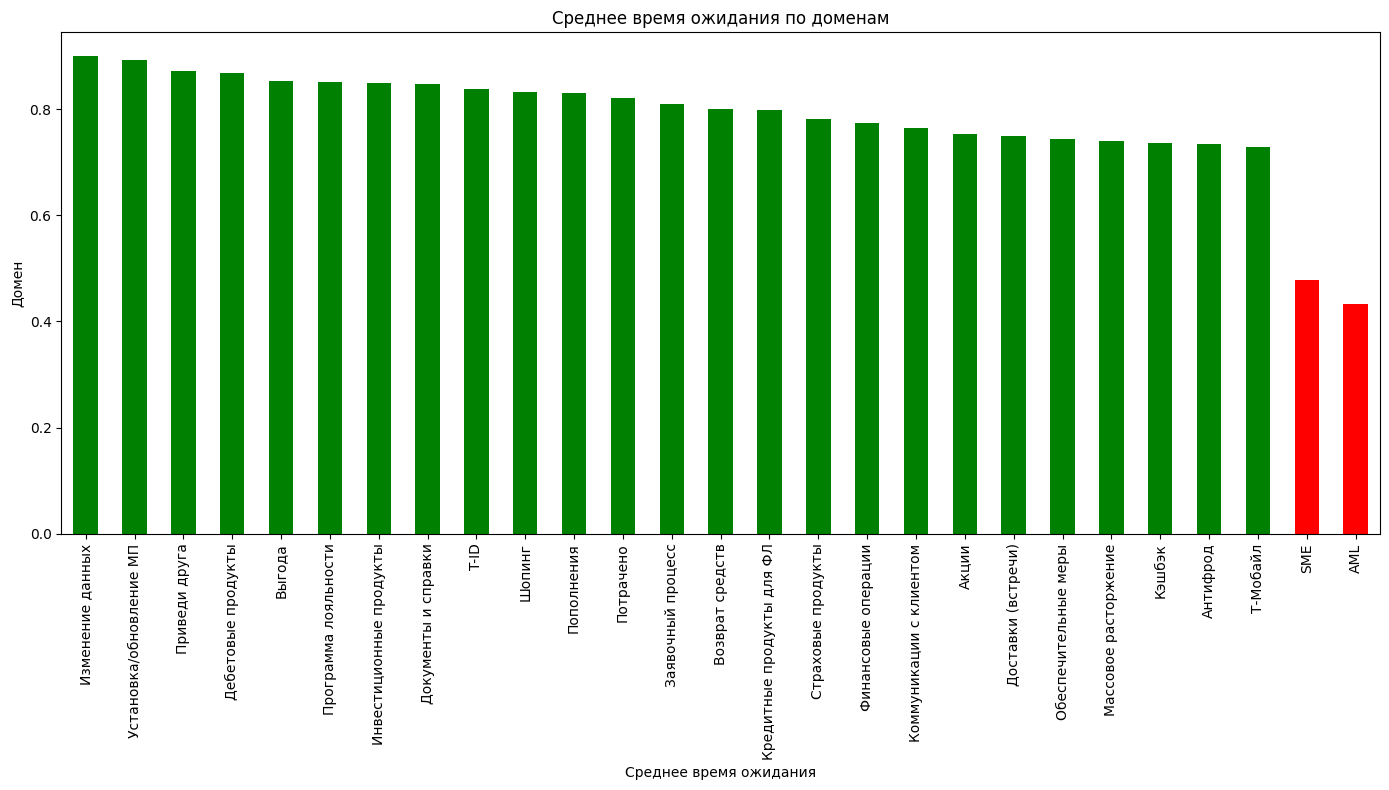

In [63]:
X = df.copy()
X = X.dropna(subset=['transfer_cnt'])
X.drop(['help_line_calls_cnt', 'task_cnt'], axis=1, inplace=True)
X['client_type_nm'] = X['client_type_nm'].fillna('NAN')
X['subscription_nm'] = X['subscription_nm'].fillna('NAN')
X['final_grade_code'] = X['final_grade_code'].fillna('NAN')
X.dropna(inplace=True)
X['time_diff'] = X['appeal_time_sec'] - X['employee_dialog_time_sec'] - X['bot_dialog_time_sec']

Q1 = X['time_diff'].quantile(0.25)
Q3 = X['time_diff'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X = X[(X['time_diff'] >= lower_bound) & (X['time_diff'] <= upper_bound)]
X = X[X['time_diff'] > 0]

y = X['csat_score']

# Заменяем resolved/unresolved на 1/0
X['resolved_numeric'] = X['problem_status_code'].map({'RESOLVED': 1, 'UNRESOLVED': 0})

resolved_ratio = X.groupby('domain_nm')['resolved_numeric'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
resolved_ratio.plot(kind='bar', color=['green' if x > 0.5 else 'red' for x in resolved_ratio])

plt.title('Среднее время ожидания по доменам')
plt.xlabel('Среднее время ожидания')
plt.ylabel('Домен')
plt.tight_layout()
plt.show()

In [71]:
# Правильное вычисление метрик
domain_metrics = X.groupby('domain_nm').agg(
    avg_wait_time=('time_diff', 'mean'),
    avg_csat_score=('csat_score', 'mean'),
    solved_ratio=('resolved_numeric', 'mean'),
    request_count=('time_diff', 'count')  # Считаем количество записей по любому столбцу
).reset_index().round(3)

# Альтернативно можно использовать:
# domain_metrics = X.groupby('domain_nm').size().reset_index(name='request_count')
# и затем объединить с другими метриками

print("Первые 5 строк данных:")
print(domain_metrics.head())
print(f"\nВсего доменов: {len(domain_metrics)}")
print(f"Общее количество заявок: {domain_metrics['request_count'].sum()}")

Первые 5 строк данных:
  domain_nm  avg_wait_time  avg_csat_score  solved_ratio  request_count
0       AML         39.860           4.033         0.433           1007
1       SME         22.401           4.675         0.477           2377
2      T-ID         38.321           4.483         0.839           3543
3     Акции         31.014           4.145         0.754             69
4  Антифрод         64.861           4.093         0.734           6396

Всего доменов: 27
Общее количество заявок: 76166


Доменов с ≥10 заявками и CSAT оценками: 27
Средний CSAT: 4.40
Среднее время ожидания: 37.79


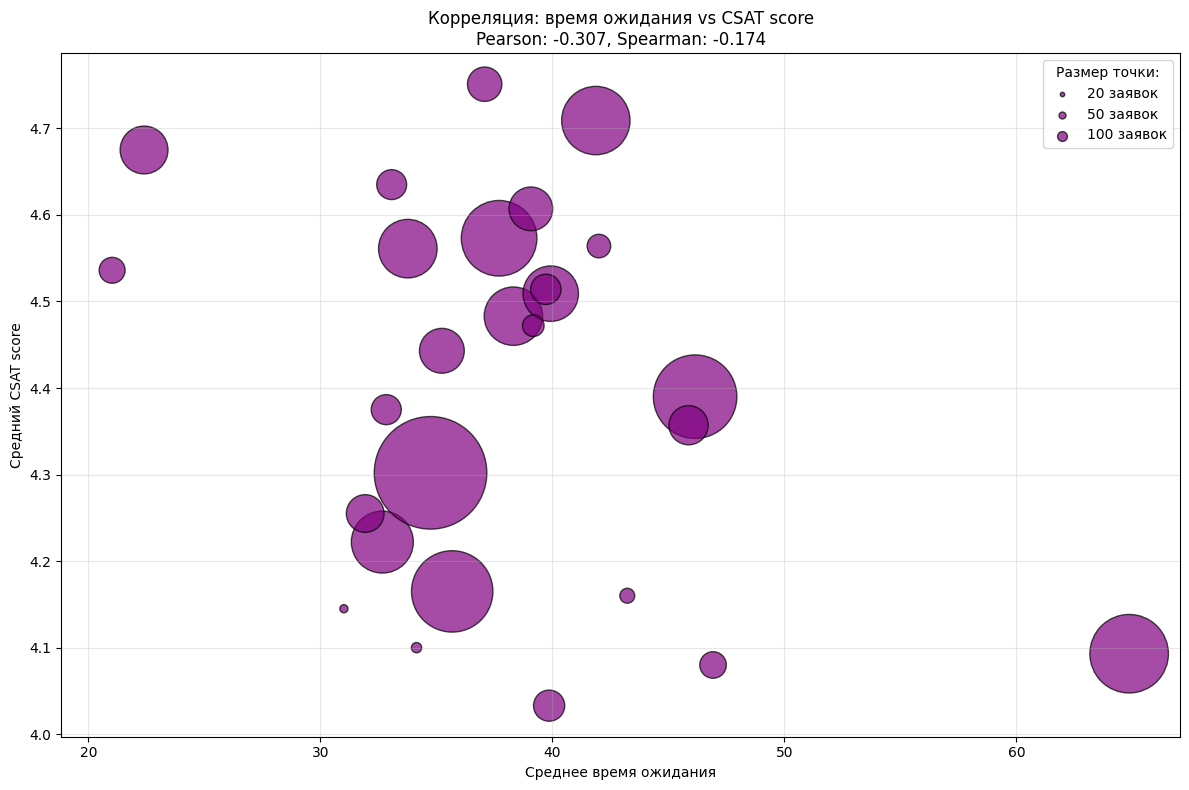

In [72]:
# Фильтруем домены с достаточным количеством данных
domain_filtered = domain_metrics[
    (domain_metrics['request_count'] >= 10) & 
    (domain_metrics['avg_csat_score'].notnull())
]

print(f"Доменов с ≥10 заявками и CSAT оценками: {len(domain_filtered)}")
print(f"Средний CSAT: {domain_filtered['avg_csat_score'].mean():.2f}")
print(f"Среднее время ожидания: {domain_filtered['avg_wait_time'].mean():.2f}")

# Scatter plot с корреляцией
plt.figure(figsize=(12, 8))

corr_pearson = domain_filtered['avg_wait_time'].corr(domain_filtered['avg_csat_score'])
corr_spearman = domain_filtered['avg_wait_time'].corr(domain_filtered['avg_csat_score'], method='spearman')

scatter = plt.scatter(domain_filtered['avg_wait_time'], 
                     domain_filtered['avg_csat_score'],
                     s=domain_filtered['request_count']/2,  # размер точек
                     alpha=0.7, c='purple', edgecolors='black')

plt.title(f'Корреляция: время ожидания vs CSAT score\nPearson: {corr_pearson:.3f}, Spearman: {corr_spearman:.3f}')
plt.xlabel('Среднее время ожидания')
plt.ylabel('Средний CSAT score')
plt.grid(True, alpha=0.3)

# Добавляем легенду
for count in [20, 50, 100]:
    plt.scatter([], [], s=count/2, alpha=0.7, c='purple', edgecolors='black', 
                label=f'{count} заявок')
plt.legend(title='Размер точки:')

plt.tight_layout()
plt.show()

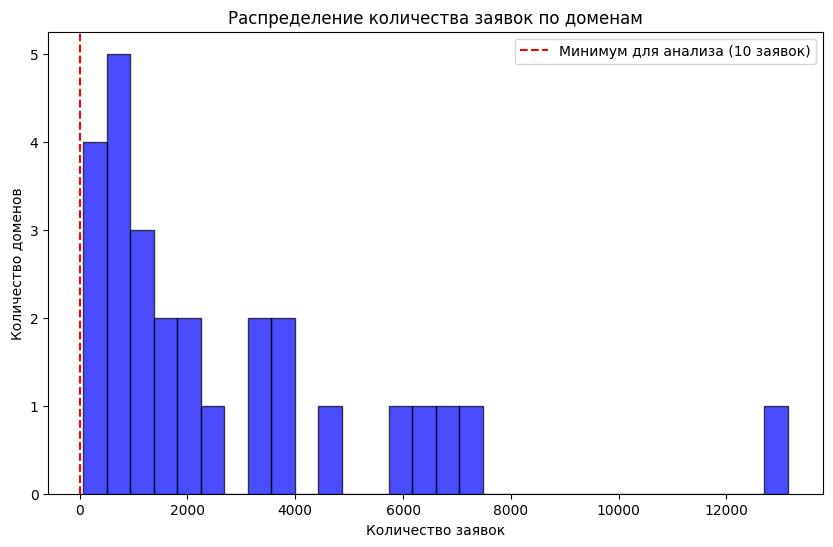

Статистика по количеству заявок на домен:
count       27.000000
mean      2820.962963
std       2997.425299
min         69.000000
25%        831.500000
50%       1593.000000
75%       3771.500000
max      13140.000000
Name: request_count, dtype: float64

Доменов с 1 заявкой: 0
Доменов с ≥10 заявками: 27


In [73]:
# Анализируем распределение количества заявок по доменам
plt.figure(figsize=(10, 6))
plt.hist(domain_metrics['request_count'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение количества заявок по доменам')
plt.xlabel('Количество заявок')
plt.ylabel('Количество доменов')
plt.axvline(x=10, color='red', linestyle='--', label='Минимум для анализа (10 заявок)')
plt.legend()
plt.show()

print("Статистика по количеству заявок на домен:")
print(domain_metrics['request_count'].describe())
print(f"\nДоменов с 1 заявкой: {(domain_metrics['request_count'] == 1).sum()}")
print(f"Доменов с ≥10 заявками: {(domain_metrics['request_count'] >= 10).sum()}")

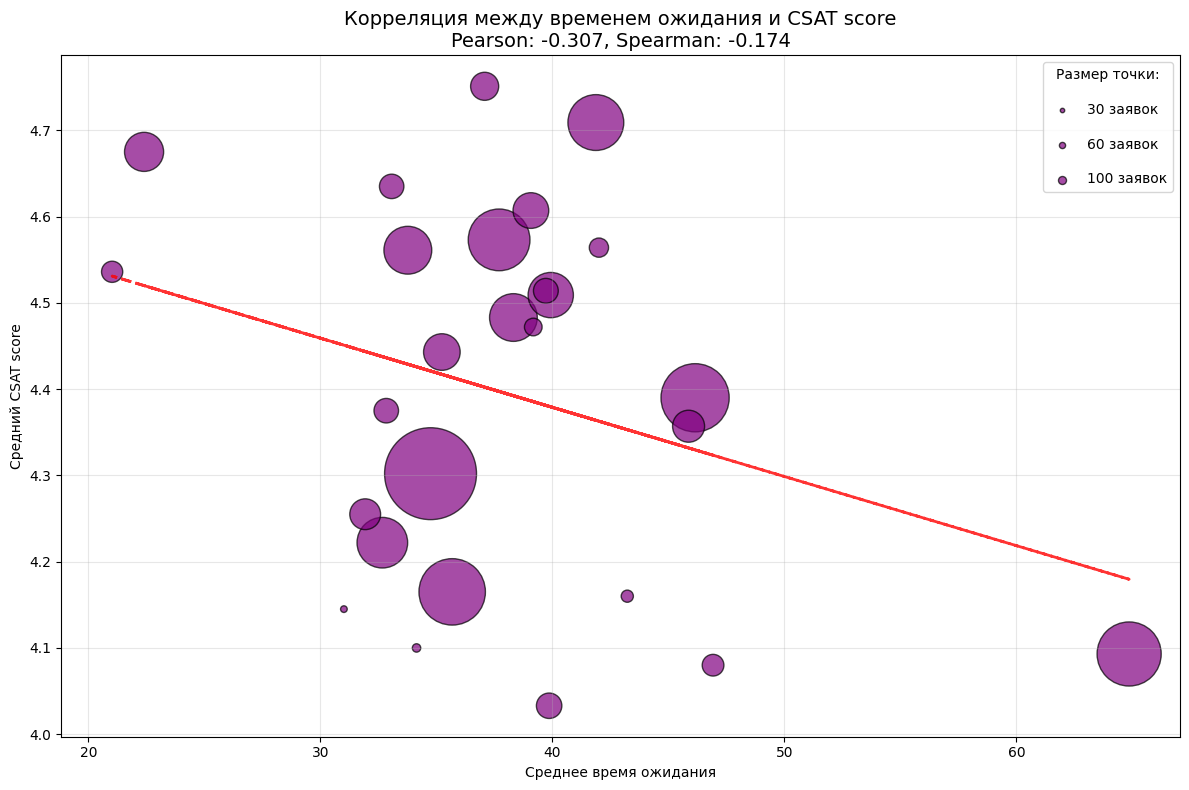

In [74]:
plt.figure(figsize=(12, 8))

# Вычисляем коэффициенты корреляции
corr_pearson = domain_metrics['avg_wait_time'].corr(domain_metrics['avg_csat_score'])
corr_spearman = domain_metrics['avg_wait_time'].corr(domain_metrics['avg_csat_score'], method='spearman')

# Scatter plot
scatter = plt.scatter(domain_metrics['avg_wait_time'], 
                     domain_metrics['avg_csat_score'],
                     s=domain_metrics['request_count']/3,  # размер точек
                     alpha=0.7, c='purple', edgecolors='black')

plt.title(f'Корреляция между временем ожидания и CSAT score\n'
          f'Pearson: {corr_pearson:.3f}, Spearman: {corr_spearman:.3f}', 
          fontsize=14)
plt.xlabel('Среднее время ожидания')
plt.ylabel('Средний CSAT score')
plt.grid(True, alpha=0.3)

# Линия регрессии
z = np.polyfit(domain_metrics['avg_wait_time'], 
               domain_metrics['avg_csat_score'], 1)
p = np.poly1d(z)
plt.plot(domain_metrics['avg_wait_time'], 
         p(domain_metrics['avg_wait_time']), 
         "r--", alpha=0.8, linewidth=2)

# Легенда для размера точек
for count in [30, 60, 100]:
    plt.scatter([], [], s=count/3, alpha=0.7, c='purple', edgecolors='black', 
                label=f'{count} заявок')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1.5, title='Размер точки:')

plt.tight_layout()
plt.show()

In [76]:
# Статистическая значимость корреляции
pearson_corr, pearson_p = stats.pearsonr(domain_metrics['avg_wait_time'], 
                                        domain_metrics['avg_csat_score'])
spearman_corr, spearman_p = stats.spearmanr(domain_metrics['avg_wait_time'], 
                                          domain_metrics['avg_csat_score'])

print("СТАТИСТИЧЕСКИЙ АНАЛИЗ КОРРЕЛЯЦИИ: Время ожидания vs CSAT")
print("=" * 60)
print(f"Коэффициент корреляции Пирсона: {pearson_corr:.3f}")
print(f"p-value (Пирсон): {pearson_p:.4f}")
print(f"Статистически значимо (p < 0.05): {pearson_p < 0.05}")
print()
print(f"Коэффициент корреляции Спирмена: {spearman_corr:.3f}")
print(f"p-value (Спирмен): {spearman_p:.4f}")
print(f"Статистически значимо (p < 0.05): {spearman_p < 0.05}")

СТАТИСТИЧЕСКИЙ АНАЛИЗ КОРРЕЛЯЦИИ: Время ожидания vs CSAT
Коэффициент корреляции Пирсона: -0.307
p-value (Пирсон): 0.1194
Статистически значимо (p < 0.05): False

Коэффициент корреляции Спирмена: -0.174
p-value (Спирмен): 0.3854
Статистически значимо (p < 0.05): False
